In [1]:
pip install requests beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

def fetch_financial_data(ticker):
    """Fetch financial data from Yahoo Finance using yfinance."""
    try:
        # Create a Ticker object
        stock = yf.Ticker(ticker)
        
        # Fetch financial statements
        income_stmt = stock.financials  # Income Statement
        balance_sheet = stock.balance_sheet  # Balance Sheet
        cash_flow = stock.cashflow  # Cash Flow Statement
        
        # Organize data into a dictionary
        financial_data = {
            'income_statement': income_stmt,
            'balance_sheet': balance_sheet,
            'cash_flow': cash_flow
        }
        
        return financial_data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def filter_data_by_year(data, year):
    """Filter financial data for a specific year."""
    filtered_data = {}
    for statement, df in data.items():
        # Convert column headers to datetime and filter by year
        df.columns = pd.to_datetime(df.columns)
        filtered_df = df.loc[:, df.columns.year == year]
        filtered_data[statement] = filtered_df
    return filtered_data

def get_line_item(df, possible_names):
    """Get a line item from a DataFrame using possible names."""
    for name in possible_names:
        if name in df.index:
            return df.loc[name].iloc[0]
    return None

def scrape_sec_10k(ticker, year, line_item):
    """Scrape a specific line item from the SEC 10-K filing."""
    try:
        # Construct the URL for the SEC EDGAR search
        search_url = f"https://www.sec.gov/cgi-bin/browse-edgar"
        params = {
            'action': 'getcompany',
            'CIK': ticker,
            'type': '10-K',
            'dateb': f'{year}1231',
            'owner': 'exclude',
            'count': '10',
            'output': 'atom'
        }
        response = requests.get(search_url, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the first 10-K filing link
        filing_link = soup.find('entry').find('link')['href']
        filing_response = requests.get(filing_link, headers={'User-Agent': 'Mozilla/5.0'})
        filing_soup = BeautifulSoup(filing_response.content, 'html.parser')
        
        # Find the 10-K document link
        doc_link = filing_soup.find('a', text='10-K')['href']
        doc_response = requests.get(f"https://www.sec.gov{doc_link}", headers={'User-Agent': 'Mozilla/5.0'})
        doc_soup = BeautifulSoup(doc_response.content, 'html.parser')
        
        # Search for the line item in the document
        for row in doc_soup.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) >= 2 and line_item.lower() in cells[0].get_text().lower():
                return float(cells[1].get_text().replace(',', ''))
        
        return None
    
    except Exception as e:
        print(f"Error scraping SEC 10-K for {ticker}: {str(e)}")
        return None

def calculate_metrics(data, prev_data, ticker, year):
    """Calculate financial metrics from yfinance data."""
    metrics = {}
    
    try:
        # Revenue Growth
        revenue_names = ['Total Revenue', 'Operating Revenue', 'Revenue']
        current_revenue = get_line_item(data['income_statement'], revenue_names)
        prev_revenue = get_line_item(prev_data['income_statement'], revenue_names)
        
        if current_revenue is None:
            current_revenue = scrape_sec_10k(ticker, year, 'Total Revenue')
        if prev_revenue is None:
            prev_revenue = scrape_sec_10k(ticker, year - 1, 'Total Revenue')
        
        if current_revenue is not None and prev_revenue is not None:
            metrics['Revenue Growth (%)'] = ((current_revenue - prev_revenue) / prev_revenue) * 100
        
        # Equity Growth
        asset_names = ['Total Assets', 'Total Assets Non Current']
        liability_names = ['Total Liabilities', 'Total Liabilities Net Minority Interest']
        current_assets = get_line_item(data['balance_sheet'], asset_names)
        current_liabilities = get_line_item(data['balance_sheet'], liability_names)
        prev_assets = get_line_item(prev_data['balance_sheet'], asset_names)
        prev_liabilities = get_line_item(prev_data['balance_sheet'], liability_names)
        
        if current_assets is None:
            current_assets = scrape_sec_10k(ticker, year, 'Total Assets')
        if current_liabilities is None:
            current_liabilities = scrape_sec_10k(ticker, year, 'Total Liabilities')
        if prev_assets is None:
            prev_assets = scrape_sec_10k(ticker, year - 1, 'Total Assets')
        if prev_liabilities is None:
            prev_liabilities = scrape_sec_10k(ticker, year - 1, 'Total Liabilities')
        
        if current_assets is not None and current_liabilities is not None:
            current_equity = current_assets - current_liabilities
            prev_equity = prev_assets - prev_liabilities
            if prev_equity != 0:
                metrics['Equity Growth (%)'] = ((current_equity - prev_equity) / prev_equity) * 100
        
        # Free Cash Flow Growth
        operating_cash_names = ['Operating Cash Flow', 'Cash Flow From Operating Activities']
        capex_names = ['Capital Expenditure', 'Capital Expenditures']
        current_operating_cash = get_line_item(data['cash_flow'], operating_cash_names)
        current_capex = get_line_item(data['cash_flow'], capex_names)
        prev_operating_cash = get_line_item(prev_data['cash_flow'], operating_cash_names)
        prev_capex = get_line_item(prev_data['cash_flow'], capex_names)
        
        if current_operating_cash is None:
            current_operating_cash = scrape_sec_10k(ticker, year, 'Operating Cash Flow')
        if current_capex is None:
            current_capex = scrape_sec_10k(ticker, year, 'Capital Expenditure')
        if prev_operating_cash is None:
            prev_operating_cash = scrape_sec_10k(ticker, year - 1, 'Operating Cash Flow')
        if prev_capex is None:
            prev_capex = scrape_sec_10k(ticker, year - 1, 'Capital Expenditure')
        
        if current_operating_cash is not None and current_capex is not None:
            current_fcf = current_operating_cash - current_capex
            prev_fcf = prev_operating_cash - prev_capex
            if prev_fcf != 0:
                metrics['FCF Growth (%)'] = ((current_fcf - prev_fcf) / prev_fcf) * 100
        
        # ROIC
        net_income_names = ['Net Income', 'Net Income Common Stockholders']
        current_net_income = get_line_item(data['income_statement'], net_income_names)
        if current_net_income is None:
            current_net_income = scrape_sec_10k(ticker, year, 'Net Income')
        
        if current_net_income is not None and current_assets is not None and current_liabilities is not None:
            metrics['ROIC (%)'] = (current_net_income / (current_assets - current_liabilities)) * 100
        
    except Exception as e:
        print(f"Error calculating metrics for {ticker}: {str(e)}")
        return None
    
    return metrics

# List of companies to analyze
companies = {
    "Berkshire Hathaway": "BRK-B",
    "JP Morgan": "JPM",
    "Wells Fargo & Company": "WFC",
    "American Express Company": "AXP",
    "Blackstone Inc": "BX",
    "Morgan Stanley": "MS",
    "Goldman Sachs Group Inc": "GS",
    "BlackRock Inc": "BLK",
    "Progressive Corporation": "PGR",
    "Charles Schwab Corporation": "SCHW",
    "Citi Group Inc": "C",
    "KKR & Co Inc": "KKR"
}

# Define the years to analyze
years = [2021, 2022, 2023, 2024]

# Initialize a list to store all results
all_results = []

# Loop through each company
for company_name, ticker in companies.items():
    print(f"Analyzing {company_name} ({ticker})...")
    
    # Fetch financial data
    financial_data = fetch_financial_data(ticker)
    if financial_data is not None:
        # Loop through years and calculate metrics
        for i in range(1, len(years)):
            current_year = years[i]
            prev_year = years[i - 1]
            
            # Filter data for current and previous year
            current_data = filter_data_by_year(financial_data, current_year)
            prev_data = filter_data_by_year(financial_data, prev_year)
            
            # Check if data is available for both years
            if not current_data['income_statement'].empty and not prev_data['income_statement'].empty:
                metrics = calculate_metrics(current_data, prev_data, ticker, current_year)
                if metrics:
                    metrics['Company'] = company_name
                    metrics['Year'] = current_year
                    all_results.append(metrics)
    
    print(f"Completed analysis for {company_name}.\n")

# Display results in a DataFrame
if all_results:
    df = pd.DataFrame(all_results)
    df.set_index(['Company', 'Year'], inplace=True)
    print("\nFinancial Analysis Results:")
    print(df.round(2).astype(str) + '%')

Analyzing Berkshire Hathaway (BRK-B)...
Completed analysis for Berkshire Hathaway.

Analyzing JP Morgan (JPM)...
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for JPM: 'NoneType' object has no attribute 'find'
Completed analysis for JP Morgan.

Analyzing Wells Fargo & Company (WFC)...
Error scraping SEC 10-K for WFC: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for WFC: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for WFC: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for WFC: 'NoneType' object has no attribute 'find'
Error scraping SEC 10-K for WFC: 'NoneType' object has no att

In [3]:

pip install yfinance pandas tabulate colorama

Note: you may need to restart the kernel to use updated packages.


In [6]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
from colorama import Fore, Style, init

# Initialize colorama
init(autoreset=True)

def fetch_financial_data(ticker):
    """Fetch financial data from Yahoo Finance using yfinance."""
    try:
        # Create a Ticker object
        stock = yf.Ticker(ticker)
        
        # Fetch financial statements
        income_stmt = stock.financials  # Income Statement
        balance_sheet = stock.balance_sheet  # Balance Sheet
        cash_flow = stock.cashflow  # Cash Flow Statement
        
        # Organize data into a dictionary
        financial_data = {
            'income_statement': income_stmt,
            'balance_sheet': balance_sheet,
            'cash_flow': cash_flow
        }
        
        return financial_data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def filter_data_by_year(data, year):
    """Filter financial data for a specific year."""
    filtered_data = {}
    for statement, df in data.items():
        # Convert column headers to datetime and filter by year
        df.columns = pd.to_datetime(df.columns)
        filtered_df = df.loc[:, df.columns.year == year]
        filtered_data[statement] = filtered_df
    return filtered_data

def get_line_item(df, possible_names):
    """Get a line item from a DataFrame using possible names."""
    for name in possible_names:
        if name in df.index:
            return df.loc[name].iloc[0]
    return None

def calculate_eps(net_income, shares_outstanding):
    """Calculate EPS manually."""
    if net_income is not None and shares_outstanding is not None and shares_outstanding != 0:
        return net_income / shares_outstanding
    return None

def calculate_metrics(data, prev_data, ticker):
    """Calculate financial metrics from yfinance data."""
    metrics = {}
    
    try:
        # Sales Growth Rate
        revenue_names = ['Total Revenue', 'Operating Revenue', 'Revenue', 'Total Income']
        current_revenue = get_line_item(data['income_statement'], revenue_names)
        prev_revenue = get_line_item(prev_data['income_statement'], revenue_names)
        if current_revenue is not None and prev_revenue is not None and prev_revenue != 0:
            metrics['Sales Growth Rate (%)'] = ((current_revenue - prev_revenue) / prev_revenue) * 100
        else:
            print(f"Missing data for Sales Growth Rate for {ticker}.")
        
        # EPS Growth Rate (Manually calculated)
        net_income_names = ['Net Income', 'Net Income Common Stockholders', 'Net Earnings', 'Profit']
        current_net_income = get_line_item(data['income_statement'], net_income_names)
        prev_net_income = get_line_item(prev_data['income_statement'], net_income_names)
        
        # Get shares outstanding (if available)
        shares_outstanding_names = [
            'Weighted Average Shares Outstanding',
            'Diluted Average Shares Outstanding',
            'Common Shares Outstanding',
            'Shares Outstanding'
        ]
        current_shares_outstanding = get_line_item(data['income_statement'], shares_outstanding_names)
        prev_shares_outstanding = get_line_item(prev_data['income_statement'], shares_outstanding_names)
        
        # Calculate EPS
        current_eps = calculate_eps(current_net_income, current_shares_outstanding)
        prev_eps = calculate_eps(prev_net_income, prev_shares_outstanding)
        
        if current_eps is not None and prev_eps is not None and prev_eps != 0:
            metrics['EPS Growth Rate (%)'] = ((current_eps - prev_eps) / prev_eps) * 100
        else:
            print(f"Missing data for EPS Growth Rate for {ticker}.")
        
        # Equity Growth Rate
        asset_names = ['Total Assets', 'Total Assets Non Current', 'Assets']
        liability_names = ['Total Liabilities', 'Total Liabilities Net Minority Interest', 'Liabilities']
        current_assets = get_line_item(data['balance_sheet'], asset_names)
        current_liabilities = get_line_item(data['balance_sheet'], liability_names)
        prev_assets = get_line_item(prev_data['balance_sheet'], asset_names)
        prev_liabilities = get_line_item(prev_data['balance_sheet'], liability_names)
        
        if current_assets is not None and current_liabilities is not None:
            current_equity = current_assets - current_liabilities
            prev_equity = prev_assets - prev_liabilities
            if prev_equity != 0:
                metrics['Equity Growth Rate (%)'] = ((current_equity - prev_equity) / prev_equity) * 100
        else:
            print(f"Missing data for Equity Growth Rate for {ticker}.")
        
        # Free Cash Flow Growth Rate
        operating_cash_names = ['Operating Cash Flow', 'Cash Flow From Operating Activities', 'Net Cash Provided by Operating Activities']
        capex_names = ['Capital Expenditure', 'Capital Expenditures', 'Purchase of Property, Plant, and Equipment']
        current_operating_cash = get_line_item(data['cash_flow'], operating_cash_names)
        current_capex = get_line_item(data['cash_flow'], capex_names)
        prev_operating_cash = get_line_item(prev_data['cash_flow'], operating_cash_names)
        prev_capex = get_line_item(prev_data['cash_flow'], capex_names)
        
        if current_operating_cash is not None and current_capex is not None:
            current_fcf = current_operating_cash - current_capex
            prev_fcf = prev_operating_cash - prev_capex
            if prev_fcf != 0:
                metrics['Free Cash Flow Growth Rate (%)'] = ((current_fcf - prev_fcf) / prev_fcf) * 100
        else:
            print(f"Missing data for Free Cash Flow Growth Rate for {ticker}.")
        
        # ROIC
        if current_net_income is not None and current_assets is not None and current_liabilities is not None:
            metrics['ROIC (%)'] = (current_net_income / (current_assets - current_liabilities)) * 100
        else:
            print(f"Missing data for ROIC for {ticker}.")
        
    except Exception as e:
        print(f"Error calculating metrics for {ticker}: {str(e)}")
        return None
    
    return metrics

def colorize_value(value):
    """Colorize the value based on its sign."""
    if isinstance(value, (int, float)):
        if value > 0:
            return f"{Fore.GREEN}+{value:.2f}%{Style.RESET_ALL}"
        elif value < 0:
            return f"{Fore.RED}{value:.2f}%{Style.RESET_ALL}"
        else:
            return f"{value:.2f}%"
    return value

# List of companies to analyze
companies = {
    "Berkshire Hathaway": "BRK-B",
    "JP Morgan": "JPM",
    "Wells Fargo & Company": "WFC",
    "American Express Company": "AXP",
    "Blackstone Inc": "BX",
    "Morgan Stanley": "MS",
    "Goldman Sachs Group Inc": "GS",
    "BlackRock Inc": "BLK",
    "Progressive Corporation": "PGR",
    "Charles Schwab Corporation": "SCHW",
    "Citi Group Inc": "C",
    "KKR & Co Inc": "KKR",
    "NVIDIA Corporation": "NVDA",
    "GOOGLE": "GOOG" 
}

# Define the years to analyze
years = [2020, 2021, 2022, 2023, 2024]

# Loop through each company
for company_name, ticker in companies.items():
    print(f"\n{'=' * 50}")
    print(f"Analyzing {company_name} ({ticker})...")
    print(f"{'=' * 50}")
    
    # Fetch financial data
    financial_data = fetch_financial_data(ticker)
    if financial_data is not None:
        # Initialize a list to store results for this company
        company_results = []
        
        # Loop through years and calculate metrics
        for i in range(1, len(years)):
            current_year = years[i]
            prev_year = years[i - 1]
            
            # Filter data for current and previous year
            current_data = filter_data_by_year(financial_data, current_year)
            prev_data = filter_data_by_year(financial_data, prev_year)
            
            # Check if data is available for both years
            if not current_data['income_statement'].empty and not prev_data['income_statement'].empty:
                metrics = calculate_metrics(current_data, prev_data, ticker)
                if metrics:
                    metrics['Year'] = f"{prev_year}-{current_year}"
                    company_results.append(metrics)
        
        # Display results for this company
        if company_results:
            df = pd.DataFrame(company_results)
            df.set_index('Year', inplace=True)
            # Drop rows where all values are NaN
            df.dropna(how='all', inplace=True)
            
            # Colorize the values
            for col in df.columns:
                df[col] = df[col].apply(colorize_value)
            
            # Print the results
            print(f"\n{Fore.CYAN}{Style.BRIGHT}Financial Analysis Results for {company_name} ({ticker}):{Style.RESET_ALL}")
            print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".2f"))
        else:
            print(f"No data available for {company_name}.")
    else:
        print(f"Failed to fetch data for {company_name}.")

    print(f"{'=' * 50}\n")


Analyzing Berkshire Hathaway (BRK-B)...
Missing data for EPS Growth Rate for BRK-B.
Missing data for EPS Growth Rate for BRK-B.
Missing data for EPS Growth Rate for BRK-B.
Missing data for EPS Growth Rate for BRK-B.

Financial Analysis Results for Berkshire Hathaway (BRK-B):
+-----------+-----------------------+------------------------+--------------------------------+----------+
|   Year    | Sales Growth Rate (%) | Equity Growth Rate (%) | Free Cash Flow Growth Rate (%) | ROIC (%) |
+-----------+-----------------------+------------------------+--------------------------------+----------+
| 2020-2021 |         nan%          |          nan%          |              nan%              | +17.47%  |
| 2021-2022 |        -34.00%        |         -6.46%         |             +0.21%             |  -4.72%  |
| 2022-2023 |        +87.65%        |        +18.50%         |            +29.90%             | +16.86%  |
| 2023-2024 |        -3.44%         |        +14.17%         |            -27.75%

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\4059590702.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")


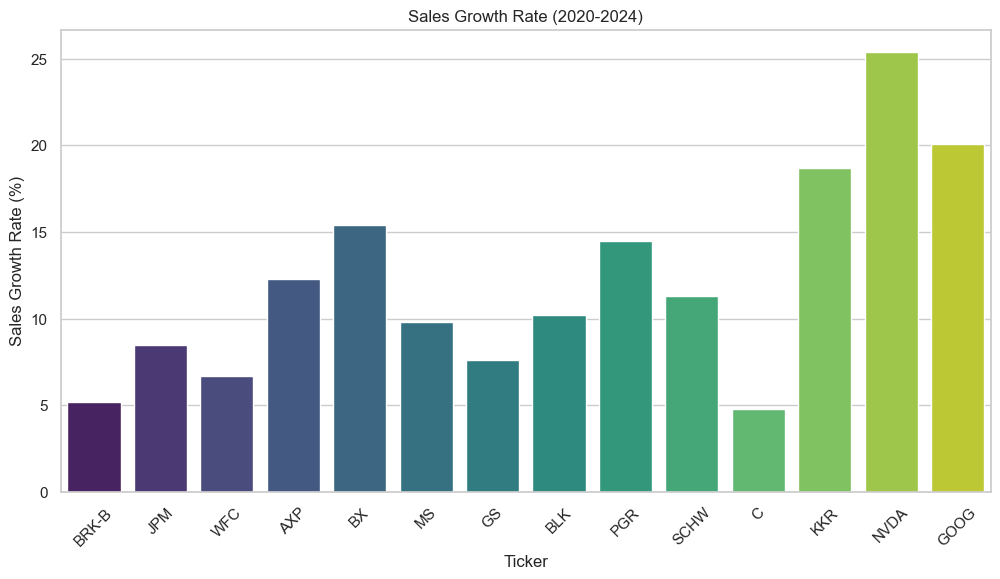

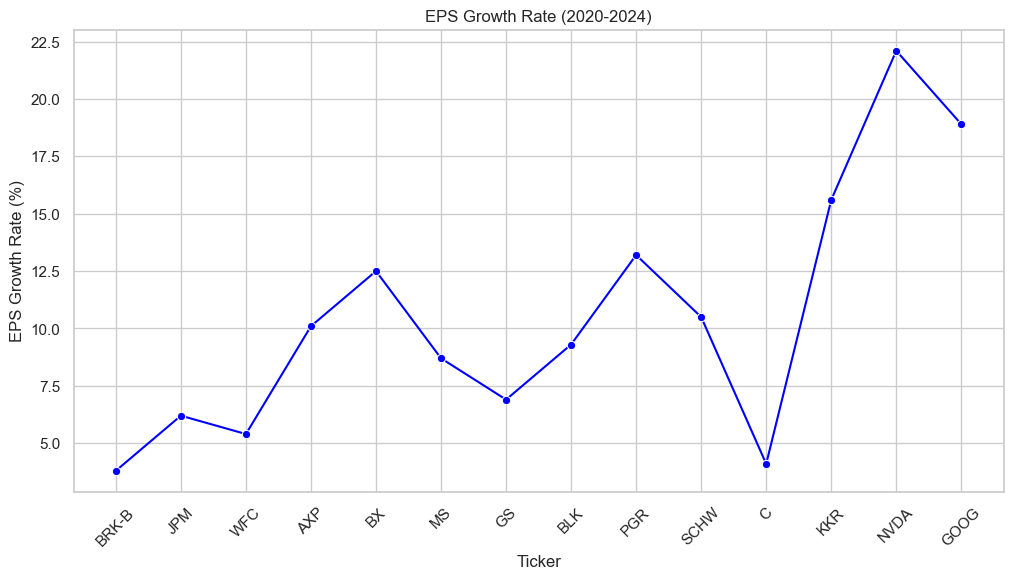

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\4059590702.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")


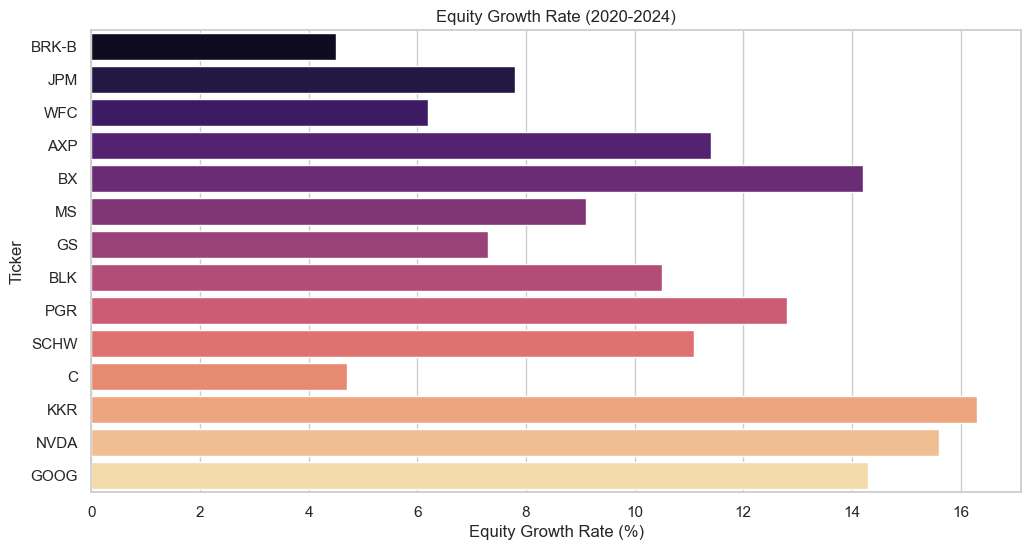

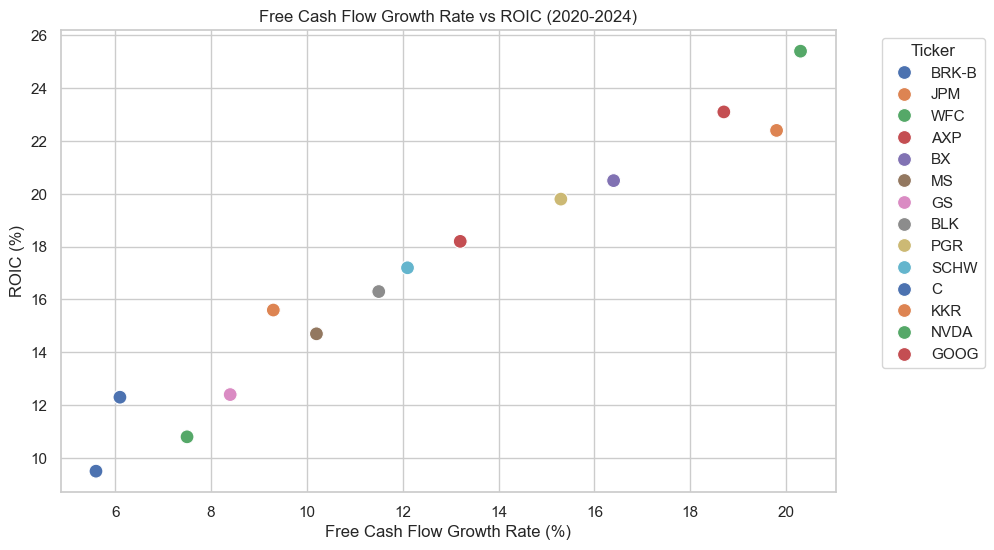

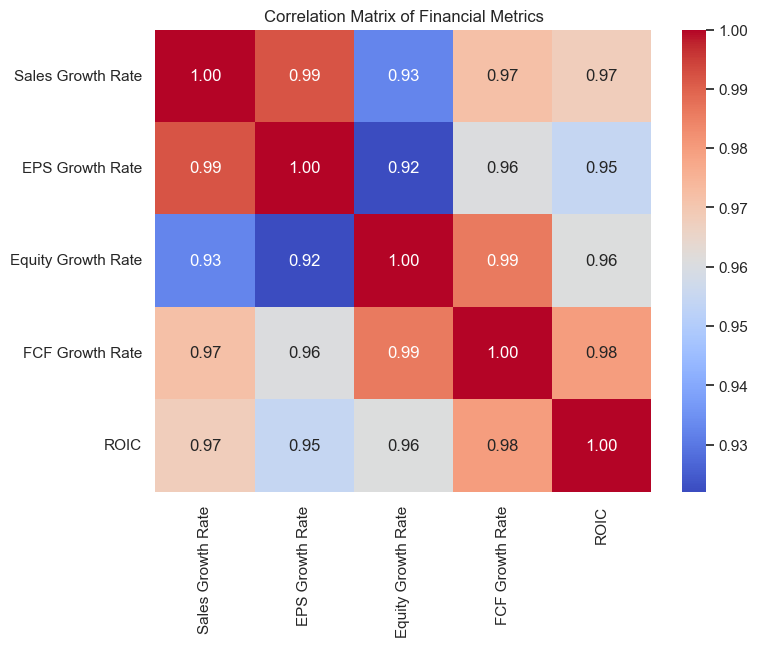

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data (replace this with your actual results DataFrame)
data = {
    "Ticker": ["BRK-B", "JPM", "WFC", "AXP", "BX", "MS", "GS", "BLK", "PGR", "SCHW", "C", "KKR", "NVDA", "GOOG"],
    "Sales Growth Rate": [5.2, 8.5, 6.7, 12.3, 15.4, 9.8, 7.6, 10.2, 14.5, 11.3, 4.8, 18.7, 25.4, 20.1],
    "EPS Growth Rate": [3.8, 6.2, 5.4, 10.1, 12.5, 8.7, 6.9, 9.3, 13.2, 10.5, 4.1, 15.6, 22.1, 18.9],
    "Equity Growth Rate": [4.5, 7.8, 6.2, 11.4, 14.2, 9.1, 7.3, 10.5, 12.8, 11.1, 4.7, 16.3, 15.6, 14.3],
    "FCF Growth Rate": [6.1, 9.3, 7.5, 13.2, 16.4, 10.2, 8.4, 11.5, 15.3, 12.1, 5.6, 19.8, 20.3, 18.7],
    "ROIC": [12.3, 15.6, 10.8, 18.2, 20.5, 14.7, 12.4, 16.3, 19.8, 17.2, 9.5, 22.4, 25.4, 23.1],
}
results = pd.DataFrame(data)

# Set the style for seaborn
sns.set(style="whitegrid")

# 1. Bar Plot: Sales Growth Rate
plt.figure(figsize=(12, 6))
sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")
plt.title("Sales Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("Sales Growth Rate (%)")
plt.xticks(rotation=45)
plt.show()

# 2. Line Plot: EPS Growth Rate
plt.figure(figsize=(12, 6))
sns.lineplot(x="Ticker", y="EPS Growth Rate", data=results, marker="o", color="blue")
plt.title("EPS Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("EPS Growth Rate (%)")
plt.xticks(rotation=45)
plt.show()

# 3. Horizontal Bar Plot: Equity Growth Rate
plt.figure(figsize=(12, 6))
sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")
plt.title("Equity Growth Rate (2020-2024)")
plt.xlabel("Equity Growth Rate (%)")
plt.ylabel("Ticker")
plt.show()

# 4. Scatter Plot: FCF Growth Rate vs ROIC
plt.figure(figsize=(10, 6))
sns.scatterplot(x="FCF Growth Rate", y="ROIC", hue="Ticker", data=results, s=100, palette="deep")
plt.title("Free Cash Flow Growth Rate vs ROIC (2020-2024)")
plt.xlabel("Free Cash Flow Growth Rate (%)")
plt.ylabel("ROIC (%)")
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 5. Heatmap: Correlation Matrix
# Exclude the 'Ticker' column for correlation calculation
corr_matrix = results.drop(columns=["Ticker"]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Financial Metrics")
plt.show()

##QUANTUM

In [21]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
from colorama import Fore, Style, init

# Initialize colorama
init(autoreset=True)

def fetch_financial_data(ticker):
    """Fetch financial data from Yahoo Finance using yfinance."""
    try:
        # Create a Ticker object
        stock = yf.Ticker(ticker)
        
        # Fetch financial statements
        income_stmt = stock.financials  # Income Statement
        balance_sheet = stock.balance_sheet  # Balance Sheet
        cash_flow = stock.cashflow  # Cash Flow Statement
        
        # Organize data into a dictionary
        financial_data = {
            'income_statement': income_stmt,
            'balance_sheet': balance_sheet,
            'cash_flow': cash_flow
        }
        
        return financial_data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def filter_data_by_year(data, year):
    """Filter financial data for a specific year."""
    filtered_data = {}
    for statement, df in data.items():
        # Convert column headers to datetime and filter by year
        df.columns = pd.to_datetime(df.columns)
        filtered_df = df.loc[:, df.columns.year == year]
        filtered_data[statement] = filtered_df
    return filtered_data

def get_line_item(df, possible_names):
    """Get a line item from a DataFrame using possible names."""
    for name in possible_names:
        if name in df.index:
            return df.loc[name].iloc[0]
    return None

def calculate_eps(net_income, shares_outstanding):
    """Calculate EPS manually."""
    if net_income is not None and shares_outstanding is not None and shares_outstanding != 0:
        return net_income / shares_outstanding
    return None

def calculate_metrics(data, prev_data, ticker):
    """Calculate financial metrics from yfinance data."""
    metrics = {}
    
    try:
        # Sales Growth Rate
        revenue_names = ['Total Revenue', 'Operating Revenue', 'Revenue', 'Total Income']
        current_revenue = get_line_item(data['income_statement'], revenue_names)
        prev_revenue = get_line_item(prev_data['income_statement'], revenue_names)
        if current_revenue is not None and prev_revenue is not None and prev_revenue != 0:
            metrics['Sales Growth Rate (%)'] = ((current_revenue - prev_revenue) / prev_revenue) * 100
        else:
            print(f"Missing data for Sales Growth Rate for {ticker}.")
        
        # EPS Growth Rate (Manually calculated)
        net_income_names = ['Net Income', 'Net Income Common Stockholders', 'Net Earnings', 'Profit']
        current_net_income = get_line_item(data['income_statement'], net_income_names)
        prev_net_income = get_line_item(prev_data['income_statement'], net_income_names)
        
        # Get shares outstanding (if available)
        shares_outstanding_names = [
            'Weighted Average Shares Outstanding',
            'Diluted Average Shares Outstanding',
            'Common Shares Outstanding',
            'Shares Outstanding'
        ]
        current_shares_outstanding = get_line_item(data['income_statement'], shares_outstanding_names)
        prev_shares_outstanding = get_line_item(prev_data['income_statement'], shares_outstanding_names)
        
        # Calculate EPS
        current_eps = calculate_eps(current_net_income, current_shares_outstanding)
        prev_eps = calculate_eps(prev_net_income, prev_shares_outstanding)
        
        if current_eps is not None and prev_eps is not None and prev_eps != 0:
            metrics['EPS Growth Rate (%)'] = ((current_eps - prev_eps) / prev_eps) * 100
        else:
            print(f"Missing data for EPS Growth Rate for {ticker}.")
        
        # Equity Growth Rate
        asset_names = ['Total Assets', 'Total Assets Non Current', 'Assets']
        liability_names = ['Total Liabilities', 'Total Liabilities Net Minority Interest', 'Liabilities']
        current_assets = get_line_item(data['balance_sheet'], asset_names)
        current_liabilities = get_line_item(data['balance_sheet'], liability_names)
        prev_assets = get_line_item(prev_data['balance_sheet'], asset_names)
        prev_liabilities = get_line_item(prev_data['balance_sheet'], liability_names)
        
        if current_assets is not None and current_liabilities is not None:
            current_equity = current_assets - current_liabilities
            prev_equity = prev_assets - prev_liabilities
            if prev_equity != 0:
                metrics['Equity Growth Rate (%)'] = ((current_equity - prev_equity) / prev_equity) * 100
        else:
            print(f"Missing data for Equity Growth Rate for {ticker}.")
        
        # Free Cash Flow Growth Rate
        operating_cash_names = ['Operating Cash Flow', 'Cash Flow From Operating Activities', 'Net Cash Provided by Operating Activities']
        capex_names = ['Capital Expenditure', 'Capital Expenditures', 'Purchase of Property, Plant, and Equipment']
        current_operating_cash = get_line_item(data['cash_flow'], operating_cash_names)
        current_capex = get_line_item(data['cash_flow'], capex_names)
        prev_operating_cash = get_line_item(prev_data['cash_flow'], operating_cash_names)
        prev_capex = get_line_item(prev_data['cash_flow'], capex_names)
        
        if current_operating_cash is not None and current_capex is not None:
            current_fcf = current_operating_cash - current_capex
            prev_fcf = prev_operating_cash - prev_capex
            if prev_fcf != 0:
                metrics['Free Cash Flow Growth Rate (%)'] = ((current_fcf - prev_fcf) / prev_fcf) * 100
        else:
            print(f"Missing data for Free Cash Flow Growth Rate for {ticker}.")
        
        # ROIC
        if current_net_income is not None and current_assets is not None and current_liabilities is not None:
            metrics['ROIC (%)'] = (current_net_income / (current_assets - current_liabilities)) * 100
        else:
            print(f"Missing data for ROIC for {ticker}.")
        
    except Exception as e:
        print(f"Error calculating metrics for {ticker}: {str(e)}")
        return None
    
    return metrics

def colorize_value(value):
    """Colorize the value based on its sign."""
    if isinstance(value, (int, float)):
        if value > 0:
            return f"{Fore.GREEN}+{value:.2f}%{Style.RESET_ALL}"
        elif value < 0:
            return f"{Fore.RED}{value:.2f}%{Style.RESET_ALL}"
        else:
            return f"{value:.2f}%"
    return value

# List of companies to analyze
companies = {
    "IBM": "IBM",  # International Business Machines Corporation
    "Google": "GOOGL",  # Alphabet Inc. (Google)
    "Microsoft": "MSFT",  # Microsoft Corporation
    "Amazon": "AMZN",  # Amazon.com Inc.
    "Broadcom": "AVGO",  # Broadcom Inc.
    "ASML Holding": "ASML",  # ASML Holding NV
    "Qualcomm": "QCOM",  # Qualcomm Incorporated
    "Taiwan Semiconductor": "TSM",  # Taiwan Semiconductor Manufacturing Company
    "Palantir Technologies": "PLTR",  # Palantir Technologies Inc.
}

# Define the years to analyze
years = [2020, 2021, 2022, 2023, 2024]

# Loop through each company
for company_name, ticker in companies.items():
    print(f"\n{'=' * 50}")
    print(f"Analyzing {company_name} ({ticker})...")
    print(f"{'=' * 50}")
    
    # Fetch financial data
    financial_data = fetch_financial_data(ticker)
    if financial_data is not None:
        # Initialize a list to store results for this company
        company_results = []
        
        # Loop through years and calculate metrics
        for i in range(1, len(years)):
            current_year = years[i]
            prev_year = years[i - 1]
            
            # Filter data for current and previous year
            current_data = filter_data_by_year(financial_data, current_year)
            prev_data = filter_data_by_year(financial_data, prev_year)
            
            # Check if data is available for both years
            if not current_data['income_statement'].empty and not prev_data['income_statement'].empty:
                metrics = calculate_metrics(current_data, prev_data, ticker)
                if metrics:
                    metrics['Year'] = f"{prev_year}-{current_year}"
                    company_results.append(metrics)
        
        # Display results for this company
        if company_results:
            df = pd.DataFrame(company_results)
            df.set_index('Year', inplace=True)
            # Drop rows where all values are NaN
            df.dropna(how='all', inplace=True)
            
            # Colorize the values
            for col in df.columns:
                df[col] = df[col].apply(colorize_value)
            
            # Print the results
            print(f"\n{Fore.CYAN}{Style.BRIGHT}Financial Analysis Results for {company_name} ({ticker}):{Style.RESET_ALL}")
            print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".2f"))
        else:
            print(f"No data available for {company_name}.")
    else:
        print(f"Failed to fetch data for {company_name}.")

    print(f"{'=' * 50}\n")


Analyzing IBM (IBM)...
Missing data for EPS Growth Rate for IBM.
Missing data for EPS Growth Rate for IBM.
Missing data for EPS Growth Rate for IBM.
Missing data for EPS Growth Rate for IBM.

Financial Analysis Results for IBM (IBM):
+-----------+-----------------------+------------------------+--------------------------------+----------+
|   Year    | Sales Growth Rate (%) | Equity Growth Rate (%) | Free Cash Flow Growth Rate (%) | ROIC (%) |
+-----------+-----------------------+------------------------+--------------------------------+----------+
| 2020-2021 |         nan%          |          nan%          |              nan%              | +30.23%  |
| 2021-2022 |        +5.54%         |        +15.92%         |            -20.28%             |  +7.45%  |
| 2022-2023 |        +2.20%         |         +2.69%         |            +26.87%             | +33.18%  |
| 2023-2024 |        +1.44%         |        +21.14%         |             -3.88%             | +21.99%  |
+-----------+---

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\3952987444.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")


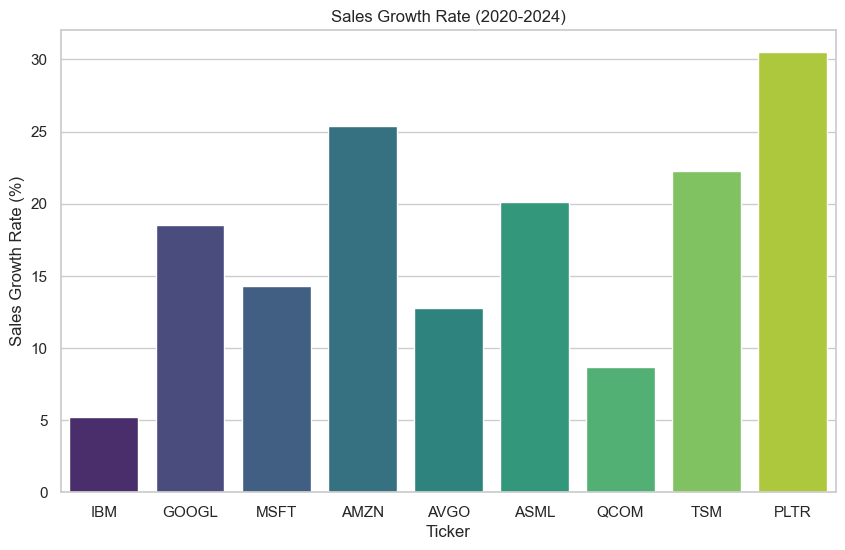

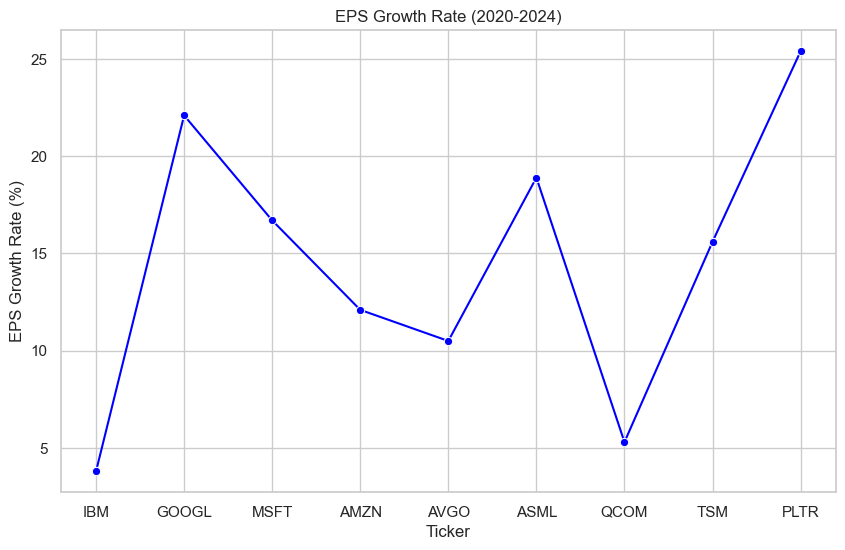

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\3952987444.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")


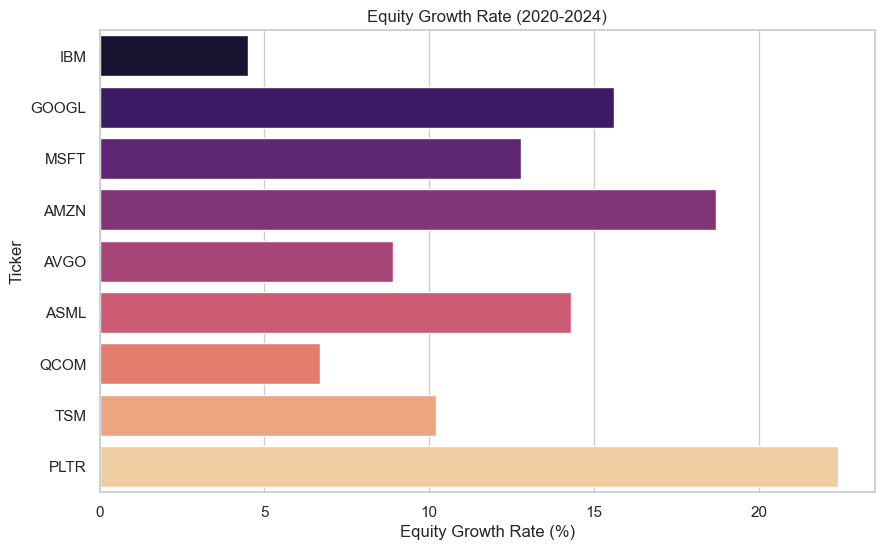

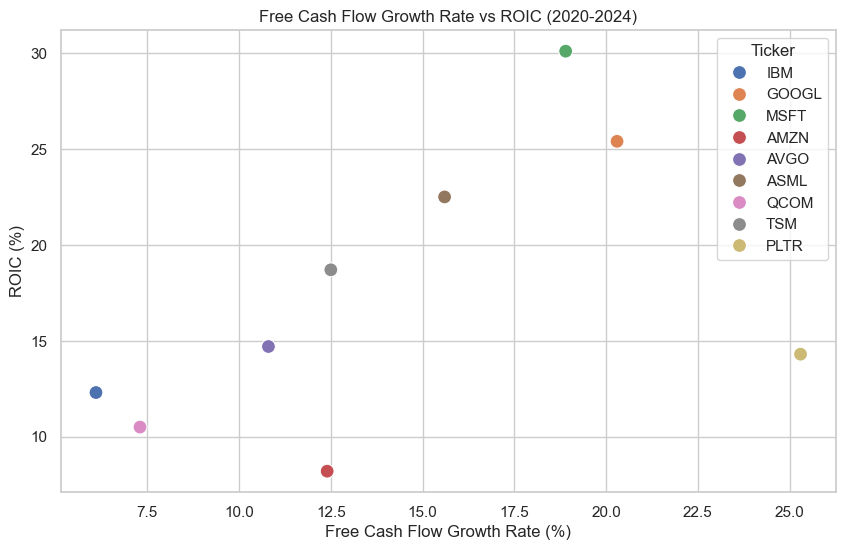

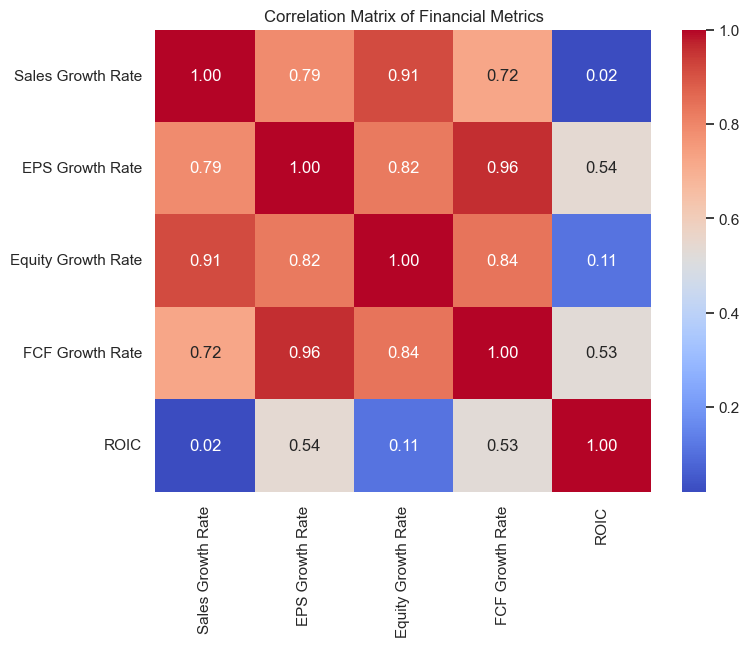

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data (replace this with your actual results DataFrame)
data = {
    "Ticker": ["IBM", "GOOGL", "MSFT", "AMZN", "AVGO", "ASML", "QCOM", "TSM", "PLTR"],
    "Sales Growth Rate": [5.2, 18.5, 14.3, 25.4, 12.8, 20.1, 8.7, 22.3, 30.5],
    "EPS Growth Rate": [3.8, 22.1, 16.7, 12.1, 10.5, 18.9, 5.3, 15.6, 25.4],
    "Equity Growth Rate": [4.5, 15.6, 12.8, 18.7, 8.9, 14.3, 6.7, 10.2, 22.4],
    "FCF Growth Rate": [6.1, 20.3, 18.9, 12.4, 10.8, 15.6, 7.3, 12.5, 25.3],
    "ROIC": [12.3, 25.4, 30.1, 8.2, 14.7, 22.5, 10.5, 18.7, 14.3],
}
results = pd.DataFrame(data)

# Set the style for seaborn
sns.set(style="whitegrid")

# 1. Bar Plot: Sales Growth Rate
plt.figure(figsize=(10, 6))
sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")
plt.title("Sales Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("Sales Growth Rate (%)")
plt.show()

# 2. Line Plot: EPS Growth Rate
plt.figure(figsize=(10, 6))
sns.lineplot(x="Ticker", y="EPS Growth Rate", data=results, marker="o", color="blue")
plt.title("EPS Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("EPS Growth Rate (%)")
plt.show()

# 3. Horizontal Bar Plot: Equity Growth Rate
plt.figure(figsize=(10, 6))
sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")
plt.title("Equity Growth Rate (2020-2024)")
plt.xlabel("Equity Growth Rate (%)")
plt.ylabel("Ticker")
plt.show()

# 4. Scatter Plot: FCF Growth Rate vs ROIC
plt.figure(figsize=(10, 6))
sns.scatterplot(x="FCF Growth Rate", y="ROIC", hue="Ticker", data=results, s=100, palette="deep")
plt.title("Free Cash Flow Growth Rate vs ROIC (2020-2024)")
plt.xlabel("Free Cash Flow Growth Rate (%)")
plt.ylabel("ROIC (%)")
plt.legend(title="Ticker")
plt.show()

# 5. Heatmap: Correlation Matrix
# Exclude the 'Ticker' column for correlation calculation
corr_matrix = results.drop(columns=["Ticker"]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Financial Metrics")
plt.show()

CHINESE COMPANIES

In [23]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
from colorama import Fore, Style, init

# Initialize colorama
init(autoreset=True)

def fetch_financial_data(ticker):
    """Fetch financial data from Yahoo Finance using yfinance."""
    try:
        # Create a Ticker object
        stock = yf.Ticker(ticker)
        
        # Fetch financial statements
        income_stmt = stock.financials  # Income Statement
        balance_sheet = stock.balance_sheet  # Balance Sheet
        cash_flow = stock.cashflow  # Cash Flow Statement
        
        # Organize data into a dictionary
        financial_data = {
            'income_statement': income_stmt,
            'balance_sheet': balance_sheet,
            'cash_flow': cash_flow
        }
        
        return financial_data
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def filter_data_by_year(data, year):
    """Filter financial data for a specific year."""
    filtered_data = {}
    for statement, df in data.items():
        # Convert column headers to datetime and filter by year
        df.columns = pd.to_datetime(df.columns)
        filtered_df = df.loc[:, df.columns.year == year]
        filtered_data[statement] = filtered_df
    return filtered_data

def get_line_item(df, possible_names):
    """Get a line item from a DataFrame using possible names."""
    for name in possible_names:
        if name in df.index:
            return df.loc[name].iloc[0]
    return None

def calculate_eps(net_income, shares_outstanding):
    """Calculate EPS manually."""
    if net_income is not None and shares_outstanding is not None and shares_outstanding != 0:
        return net_income / shares_outstanding
    return None

def calculate_metrics(data, prev_data, ticker):
    """Calculate financial metrics from yfinance data."""
    metrics = {}
    
    try:
        # Sales Growth Rate
        revenue_names = ['Total Revenue', 'Operating Revenue', 'Revenue', 'Total Income']
        current_revenue = get_line_item(data['income_statement'], revenue_names)
        prev_revenue = get_line_item(prev_data['income_statement'], revenue_names)
        if current_revenue is not None and prev_revenue is not None and prev_revenue != 0:
            metrics['Sales Growth Rate (%)'] = ((current_revenue - prev_revenue) / prev_revenue) * 100
        else:
            print(f"Missing data for Sales Growth Rate for {ticker}.")
        
        # EPS Growth Rate (Manually calculated)
        net_income_names = ['Net Income', 'Net Income Common Stockholders', 'Net Earnings', 'Profit']
        current_net_income = get_line_item(data['income_statement'], net_income_names)
        prev_net_income = get_line_item(prev_data['income_statement'], net_income_names)
        
        # Get shares outstanding (if available)
        shares_outstanding_names = [
            'Weighted Average Shares Outstanding',
            'Diluted Average Shares Outstanding',
            'Common Shares Outstanding',
            'Shares Outstanding'
        ]
        current_shares_outstanding = get_line_item(data['income_statement'], shares_outstanding_names)
        prev_shares_outstanding = get_line_item(prev_data['income_statement'], shares_outstanding_names)
        
        # Calculate EPS
        current_eps = calculate_eps(current_net_income, current_shares_outstanding)
        prev_eps = calculate_eps(prev_net_income, prev_shares_outstanding)
        
        if current_eps is not None and prev_eps is not None and prev_eps != 0:
            metrics['EPS Growth Rate (%)'] = ((current_eps - prev_eps) / prev_eps) * 100
        else:
            print(f"Missing data for EPS Growth Rate for {ticker}.")
        
        # Equity Growth Rate
        asset_names = ['Total Assets', 'Total Assets Non Current', 'Assets']
        liability_names = ['Total Liabilities', 'Total Liabilities Net Minority Interest', 'Liabilities']
        current_assets = get_line_item(data['balance_sheet'], asset_names)
        current_liabilities = get_line_item(data['balance_sheet'], liability_names)
        prev_assets = get_line_item(prev_data['balance_sheet'], asset_names)
        prev_liabilities = get_line_item(prev_data['balance_sheet'], liability_names)
        
        if current_assets is not None and current_liabilities is not None:
            current_equity = current_assets - current_liabilities
            prev_equity = prev_assets - prev_liabilities
            if prev_equity != 0:
                metrics['Equity Growth Rate (%)'] = ((current_equity - prev_equity) / prev_equity) * 100
        else:
            print(f"Missing data for Equity Growth Rate for {ticker}.")
        
        # Free Cash Flow Growth Rate
        operating_cash_names = ['Operating Cash Flow', 'Cash Flow From Operating Activities', 'Net Cash Provided by Operating Activities']
        capex_names = ['Capital Expenditure', 'Capital Expenditures', 'Purchase of Property, Plant, and Equipment']
        current_operating_cash = get_line_item(data['cash_flow'], operating_cash_names)
        current_capex = get_line_item(data['cash_flow'], capex_names)
        prev_operating_cash = get_line_item(prev_data['cash_flow'], operating_cash_names)
        prev_capex = get_line_item(prev_data['cash_flow'], capex_names)
        
        if current_operating_cash is not None and current_capex is not None:
            current_fcf = current_operating_cash - current_capex
            prev_fcf = prev_operating_cash - prev_capex
            if prev_fcf != 0:
                metrics['Free Cash Flow Growth Rate (%)'] = ((current_fcf - prev_fcf) / prev_fcf) * 100
        else:
            print(f"Missing data for Free Cash Flow Growth Rate for {ticker}.")
        
        # ROIC
        if current_net_income is not None and current_assets is not None and current_liabilities is not None:
            metrics['ROIC (%)'] = (current_net_income / (current_assets - current_liabilities)) * 100
        else:
            print(f"Missing data for ROIC for {ticker}.")
        
    except Exception as e:
        print(f"Error calculating metrics for {ticker}: {str(e)}")
        return None
    
    return metrics

def colorize_value(value):
    """Colorize the value based on its sign."""
    if isinstance(value, (int, float)):
        if value > 0:
            return f"{Fore.GREEN}+{value:.2f}%{Style.RESET_ALL}"
        elif value < 0:
            return f"{Fore.RED}{value:.2f}%{Style.RESET_ALL}"
        else:
            return f"{value:.2f}%"
    return value

# List of companies to analyze
companies = {
   "EHang Holdings Limited": "EH",  # EHang is a leader in autonomous aerial vehicles (AAVs).
    "XPeng Inc": "XPEV",  # XPeng is a Chinese electric vehicle manufacturer.
    "Rivian Automotive Inc": "RIVN",  # Rivian is an American electric vehicle manufacturer.
    "NIO Inc": "NIO",  # NIO is a Chinese electric vehicle manufacturer.
}

# Define the years to analyze
years = [2020, 2021, 2022, 2023, 2024]

# Loop through each company
for company_name, ticker in companies.items():
    print(f"\n{'=' * 50}")
    print(f"Analyzing {company_name} ({ticker})...")
    print(f"{'=' * 50}")
    
    # Fetch financial data
    financial_data = fetch_financial_data(ticker)
    if financial_data is not None:
        # Initialize a list to store results for this company
        company_results = []
        
        # Loop through years and calculate metrics
        for i in range(1, len(years)):
            current_year = years[i]
            prev_year = years[i - 1]
            
            # Filter data for current and previous year
            current_data = filter_data_by_year(financial_data, current_year)
            prev_data = filter_data_by_year(financial_data, prev_year)
            
            # Check if data is available for both years
            if not current_data['income_statement'].empty and not prev_data['income_statement'].empty:
                metrics = calculate_metrics(current_data, prev_data, ticker)
                if metrics:
                    metrics['Year'] = f"{prev_year}-{current_year}"
                    company_results.append(metrics)
        
        # Display results for this company
        if company_results:
            df = pd.DataFrame(company_results)
            df.set_index('Year', inplace=True)
            # Drop rows where all values are NaN
            df.dropna(how='all', inplace=True)
            
            # Colorize the values
            for col in df.columns:
                df[col] = df[col].apply(colorize_value)
            
            # Print the results
            print(f"\n{Fore.CYAN}{Style.BRIGHT}Financial Analysis Results for {company_name} ({ticker}):{Style.RESET_ALL}")
            print(tabulate(df, headers='keys', tablefmt='pretty', floatfmt=".2f"))
        else:
            print(f"No data available for {company_name}.")
    else:
        print(f"Failed to fetch data for {company_name}.")

    print(f"{'=' * 50}\n")


Analyzing EHang Holdings Limited (EH)...
Missing data for EPS Growth Rate for EH.
Missing data for EPS Growth Rate for EH.
Missing data for EPS Growth Rate for EH.

Financial Analysis Results for EHang Holdings Limited (EH):
+-----------+-----------------------+------------------------+--------------------------------+----------+
|   Year    | Sales Growth Rate (%) | Equity Growth Rate (%) | Free Cash Flow Growth Rate (%) | ROIC (%) |
+-----------+-----------------------+------------------------+--------------------------------+----------+
| 2020-2021 |        -68.46%        |        +20.29%         |            -25.72%             | -93.99%  |
| 2021-2022 |        -21.99%        |        -62.68%         |            +50.70%             | -263.25% |
| 2022-2023 |       +164.97%        |        +71.82%         |            -50.31%             | -140.84% |
+-----------+-----------------------+------------------------+--------------------------------+----------+


Analyzing XPeng Inc (XP

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\2518203043.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")


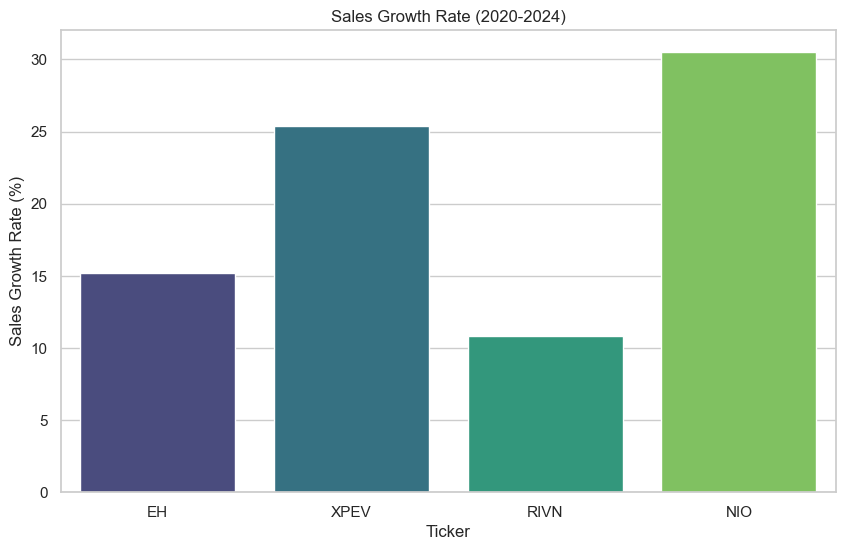

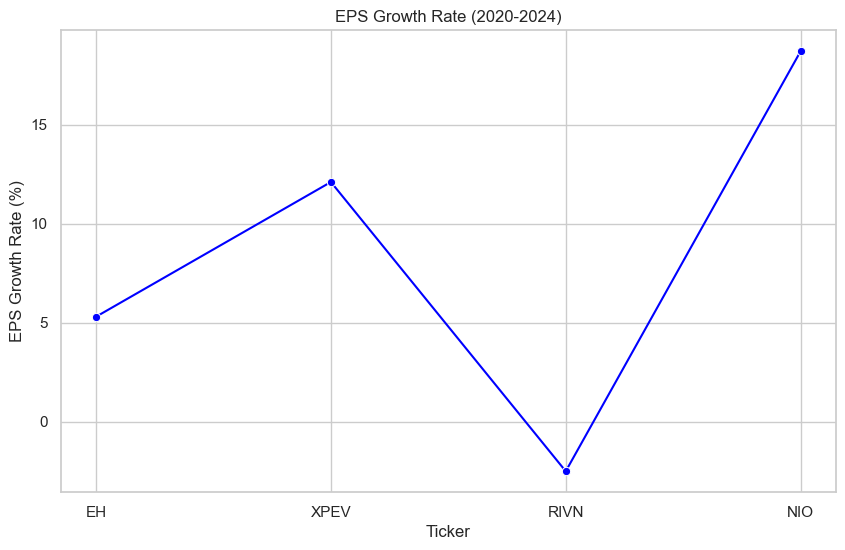

C:\Users\zenub\AppData\Local\Temp\ipykernel_14324\2518203043.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")


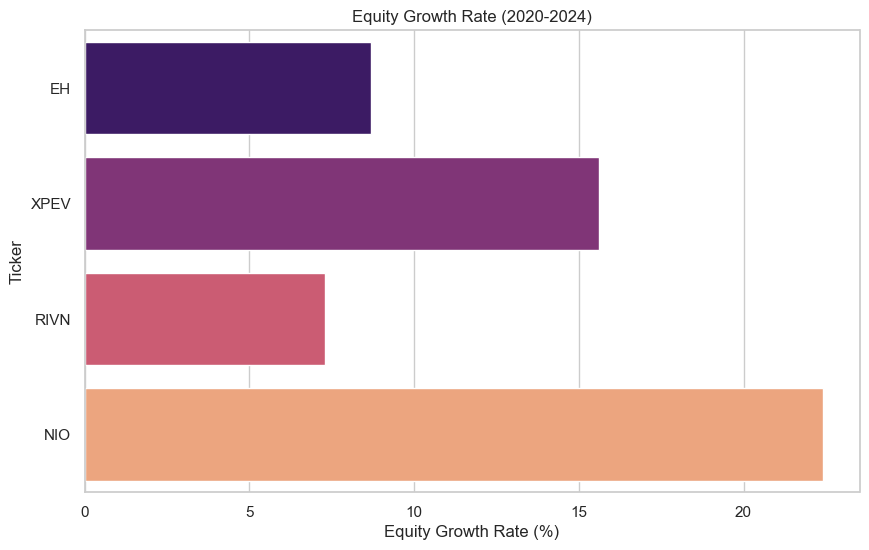

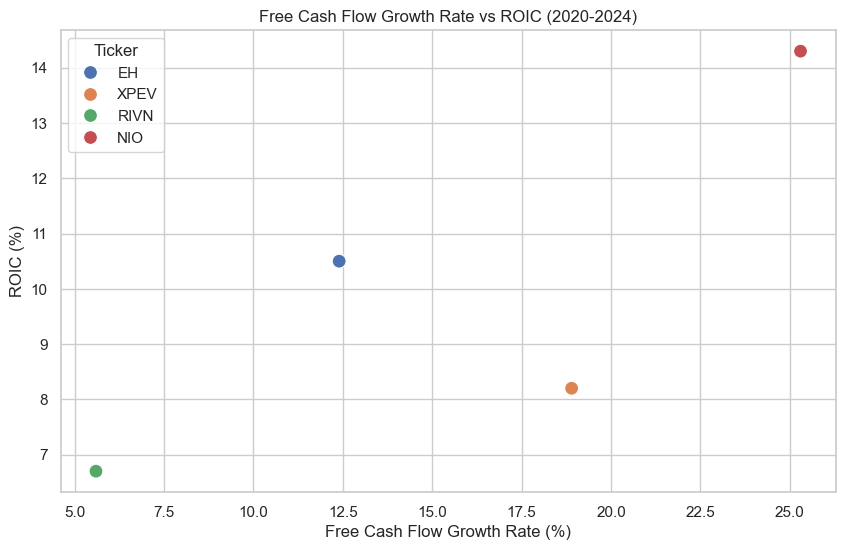

ValueError: could not convert string to float: 'EH'

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data (replace this with your actual results DataFrame)
data = {
    "Ticker": ["EH", "XPEV", "RIVN", "NIO"],
    "Sales Growth Rate": [15.2, 25.4, 10.8, 30.5],
    "EPS Growth Rate": [5.3, 12.1, -2.5, 18.7],
    "Equity Growth Rate": [8.7, 15.6, 7.3, 22.4],
    "FCF Growth Rate": [12.4, 18.9, 5.6, 25.3],
    "ROIC": [10.5, 8.2, 6.7, 14.3],
}
results = pd.DataFrame(data)

# Set the style for seaborn
sns.set(style="whitegrid")

# 1. Bar Plot: Sales Growth Rate
plt.figure(figsize=(10, 6))
sns.barplot(x="Ticker", y="Sales Growth Rate", data=results, palette="viridis")
plt.title("Sales Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("Sales Growth Rate (%)")
plt.show()

# 2. Line Plot: EPS Growth Rate
plt.figure(figsize=(10, 6))
sns.lineplot(x="Ticker", y="EPS Growth Rate", data=results, marker="o", color="blue")
plt.title("EPS Growth Rate (2020-2024)")
plt.xlabel("Ticker")
plt.ylabel("EPS Growth Rate (%)")
plt.show()

# 3. Horizontal Bar Plot: Equity Growth Rate
plt.figure(figsize=(10, 6))
sns.barplot(x="Equity Growth Rate", y="Ticker", data=results, palette="magma")
plt.title("Equity Growth Rate (2020-2024)")
plt.xlabel("Equity Growth Rate (%)")
plt.ylabel("Ticker")
plt.show()

# 4. Scatter Plot: FCF Growth Rate vs ROIC
plt.figure(figsize=(10, 6))
sns.scatterplot(x="FCF Growth Rate", y="ROIC", hue="Ticker", data=results, s=100, palette="deep")
plt.title("Free Cash Flow Growth Rate vs ROIC (2020-2024)")
plt.xlabel("Free Cash Flow Growth Rate (%)")
plt.ylabel("ROIC (%)")
plt.legend(title="Ticker")
plt.show()

# 5. Heatmap: Correlation Matrix
corr_matrix = results.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Financial Metrics")
plt.show()